<a href="https://colab.research.google.com/github/pharringtonp19/mecon/blob/main/notebooks/problem_sets/assignments/Design_Your_Own_Market_Correction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title Imports { display-mode: "form" }
%%capture 
!pip install jaxopt

import jax 
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp 
import jaxopt
import matplotlib.pyplot as plt

In [2]:
#@title Inverse { display-mode: "form" }
def inverse(f):

  def inverse_fn(y):
    
    def closure(x,y):
      return (f(x)-y)**2

    solver = jaxopt.GradientDescent(fun=closure, maxiter=2000)
    res = solver.run(jnp.ones(shape=()), y)
    return res.params

  return inverse_fn

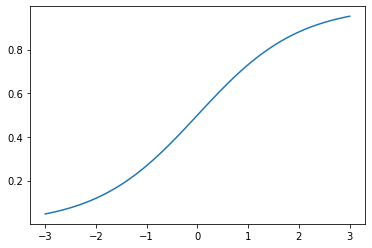

In [3]:
#@title Sigmoid Function { display-mode: "form" }
xs = jnp.linspace(-3, 3, 100)
ys = jax.vmap(jax.nn.sigmoid)(xs)
plt.plot(xs, ys)
plt.show()

In this problem set, we use the same setup as in class where we have sellers and consumers. We represent the willingness to pay under full information for the the seller (consumer) via a vector denoted by $xs(xc)$, where the first argument of the vector corresponds to their willingness to pay for a bad car and the second element corresponds to their willingness to pay for a good car. 

In [4]:
xc = jnp.array([1200, 2400])  # Consumer's willingness to pay under full information
xs = jnp.array([1000, 2000])  # Sellers's willingness to pay under full information 
u = lambda x: jnp.sqrt(x)    # The utility function

**Note**: In python we can retreive an element of a vector by indexing the vector as follow. Counting in python starts at 0!

In [5]:
vector = jnp.array([2.3, 10.6, 13.1])
vector[0] # 2.3
vector[1] # 10.6 
vector[2] # 13.1

DeviceArray(13.1, dtype=float64)

We then define the consumer's value function, the consumer's willingness to pay function (wtp), and the supply function as follows. The new feature here is the supply function. As you will see it makes use of the function `jnp.where`. This function is equivalent to the following mathematical function: 

$$
\textrm{Supply}(\textrm{price}, xs)= 
\begin{cases}
0.5, \quad \textrm{if price} \geq xs[1]\\
1, \quad \textrm{otherwise}
\end{cases}
$$
That is, if the price is greater than the seller's willingness to pay for a new car ($xs[1]$), then half of the cars in the market will be good cars and half the cars will be bad. Otherwise, all the cars will be bad. 

In [6]:
def value(p, xc, u):
  return p*u(xc[0]) + (1-p)*u(xc[1])

def wtp(p, xc, u):
  return inverse(u)(value(p, xc, u))

def supply(price, xs):
  return jnp.where(price >= xs[1], 0.5, 1.)

As discussed in class, the equilibrium price and probabily of a bad car (prob) can be computed by solving the following optimization problem. 

$$\underset{\textrm{prob}, p}{\textrm{Solve}} \ F_{X_c, X_s, u}(\textrm{prob}, p) = 0 $$

Equilibrium is defined as the root of this function $F$ which we define as follows. 

$$F_{X_s, X_c, u}(\textrm{prob}, \textrm{price}) = \begin{bmatrix} \textrm{price} - u^{-1} \circ V(\textrm{prob}, X_c, u) \\
\textrm{prob} - S(X_s, \textrm{price})
\end{bmatrix}$$

In [7]:
def F(xc, xs, u, prob, price):
  a = price - wtp(prob, xc, u)
  b = (prob - supply(price, xs))/0.001
  return jnp.array([a, b])

In [8]:
#@title Solver-related Functions { display-mode: "form" }
init_array = jnp.array([inverse(jax.nn.sigmoid)(.5), wtp(.5, xc, u)])
def solve_model(f):
  solver = jaxopt.GradientDescent(fun=f, maxiter=2000)
  res = solver.run(init_array)
  return res.params

def f(z):
  prob = jax.nn.sigmoid(z[0])
  price = jnp.abs(z[1])
  return jnp.linalg.norm(F(xc, xs, u, prob, price))

Under the current market structure the equilibrium price and probability of a bad car are:



In [9]:
a, b = solve_model(f)
print(f"Probability of a Bad Car: {jnp.round(jax.nn.sigmoid(a), 4)}\n\nConsumer's willingness to pay: {jnp.floor(b)}")

Probability of a Bad Car: 1.0

Consumer's willingness to pay: 1200.0


### **Assignment**

As discussed in class, the above is an example of market failure. That lack of information on behalf of the consumer drives the good cars out of the market. 

In this problem set, I would like you to propose a solution for this market failure. Either introduce some type of government policy, create a new type of firm, or alter the choice sets of the existing agents (consumers/sellers). Please explain in words how your proposal corrects for the market failure. Are there any unintended consequences of this proposal? Who stands to benefit the most from it?


### **Bonus** 
See if you can implement your proposal in python. Note, this isn't something I would ask you on a midterm. That said, it can be a great learning experience and help you better understand exactly how models work!